In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')  

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

# Part One: Apply and Compare Dimensionality Reduction Techniques

The goal of this question is to apply three dimensionality reduction techniques, t-Distributed Stochastic Neighbor Embedding (t-SNE), Principal Component Analysis (PCA), and Auto-Encoder (Neural Network-Based) to MNIST dataset and analyze their effectiveness in
representing handwritten digits in a 2D space.

In [7]:
# Specify the directory name

directory_name = "visualizations"

In [8]:
# Create the directory
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'visualizations' already exists.


In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [10]:
# data preparation

def load_mnist():
    """Load, normalize and  preprocess MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    
    #Combine train and test for this analysis
    X = torch.cat([train_dataset.data, test_dataset.data], dim=0).float()
    y = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)
    
    #Normalize and flatten
    X = X.view(X.shape[0], -1) / 255.0
    return X.numpy(), y.numpy()

# Principal Component Analysis

In [11]:
class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.components = None
        self.mean = None
    
    def fit(self, X):
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        #Compute covariance matrix
        cov_matrix = np.cov(X_centered.T)
        
        #Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        #Sort eigenvectors by eigenvalues in descending order
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, sorted_idx][:, :self.n_components]
        
        #Explained variance
        self.explained_variance = eigenvalues[sorted_idx][:self.n_components]
        self.explained_variance_ratio = self.explained_variance / np.sum(eigenvalues)
        
        return self
    
    def transform(self, X):
        if self.mean is None or self.components is None:
            raise RuntimeError("PCA must be fitted before transforming data")
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# t-Distributed Stochastic Neighbor Embedding

In [12]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, 
                 max_iter=1000, early_exaggeration=4, verbose=False):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.early_exaggeration = early_exaggeration
        self.verbose = verbose
    
    def _Hbeta(self, D, beta=1.0):
        """Compute H and P for a given beta (precision)"""
        P = np.exp(-D * beta)
        sumP = np.sum(P)
        H = np.log(sumP) + beta * np.sum(D * P) / sumP
        P = P / sumP
        return H, P
    
    def _x2p(self, X):
        """Compute pairwise affinities for t-SNE"""
        (n, d) = X.shape
        sum_X = np.sum(np.square(X), 1)
        D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T , sum_X)
        P = np.zeros((n, n))
        beta = np.ones((n, 1))
        logU = np.log(self.perplexity)
        
        #Binary search to find beta that produces target perplexity
        for i in range(n):
            betamin = -np.inf
            betamax = np.inf
            Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
            H, thisP = self._Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries = 0
            while np.abs(Hdiff) > 1e-5 and tries < 50:
                if Hdiff > 0:
                    betamin = beta[i].copy()
                    if betamax == np.inf:
                        beta[i] = beta[i] * 2
                    else:
                        beta[i] = (beta[i] + betamax) / 2
                else:
                    betamax = beta[i].copy()
                    if betamin == -np.inf:
                        beta[i] = beta[i] / 2
                    else:
                        beta[i] = (beta[i] + betamin) / 2
                
                H, thisP = self._Hbeta(Di, beta[i])
                Hdiff = H - logU
                tries += 1
            
            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
        return P
    
    def fit_transform(self, X):
        """Fit t-SNE model and return transformed data"""
        (n, _) = X.shape
        
        #Initialize Y randomly
        Y = np.random.randn(n, self.n_components)
        dY = np.zeros((n, self.n_components))
        iY = np.zeros((n, self.n_components))
        gains = np.ones((n, self.n_components))
        
        #Compute P-values
        P = self._x2p(X)
        P = P + np.transpose(P)
        P = P / np.sum(P)
        P = P * self.early_exaggeration
        P = np.maximum(P, 1e-12)
        
        #Run iterations
        for iter in range(self.max_iter):
            #Compute Q-values (Student-t distribution)
            sum_Y = np.sum(np.square(Y), 1)
            num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T , sum_Y))
            num[range(n), range(n)] = 0
            Q = num / np.sum(num)
            Q = np.maximum(Q, 1e-12)
            
            #Compute gradient
            PQ = P - Q
            for i in range(n):
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (self.n_components, 1)).T * (Y[i, :] - Y), 0)
            
            #Perform the update
            if iter < 20:
                momentum = 0.5
            else:
                momentum = 0.8
            gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
            gains[gains < 0.01] = 0.01
            iY = momentum * iY - self.learning_rate * (gains * dY)
            Y = Y + iY
            Y = Y - np.tile(np.mean(Y, 0), (n, 1))
            
            #Stop early exaggeration after 100 iterations
            if iter == 100:
                P = P / self.early_exaggeration
            
            #Progress output
            if self.verbose and (iter + 1) % 100 == 0:
                C = np.sum(P * np.log(P / Q))
                print(f"Iteration {iter + 1}: error is {C}")
        
        return Y

# Autoencoder

In [13]:
class Autoencoder(nn.Module):
    """Autoencoder implementation using PyTorch"""
    def __init__(self, input_dim, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [14]:
def train_autoencoder(X, input_dim, latent_dim=2, epochs=50, batch_size=128):
    """Train autoencoder and return latent representations"""
    model = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    #Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    #Training loop
    for epoch in range(epochs):
        for batch_features, _ in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            loss.backward()
            optimizer.step()
    
    #Get latent representations
    with torch.no_grad():
        latent = model.encode(X_tensor).numpy()
    
    return latent

## Visualization

In [17]:
#Load data
X, y = load_mnist()

# dimensionality reduction methods are infeasible for datasets < 10,000
sample_size = 10000
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

# Apply all techniques
print("Applying PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

print("Applying t-SNE...")
tsne = TSNE(n_components=2, max_iter=500, verbose=True)
X_tsne = tsne.fit_transform(X_sample)

print("Training Autoencoder...")
X_ae = train_autoencoder(X_sample, input_dim=X_sample.shape[1])

Applying PCA...
Applying t-SNE...
Iteration 100: error is 20.87464855335365
Iteration 200: error is 2.6368936948219863
Iteration 300: error is 2.308739107838102
Iteration 400: error is 2.1293277800585435
Iteration 500: error is 2.0119801478812183
Training Autoencoder...


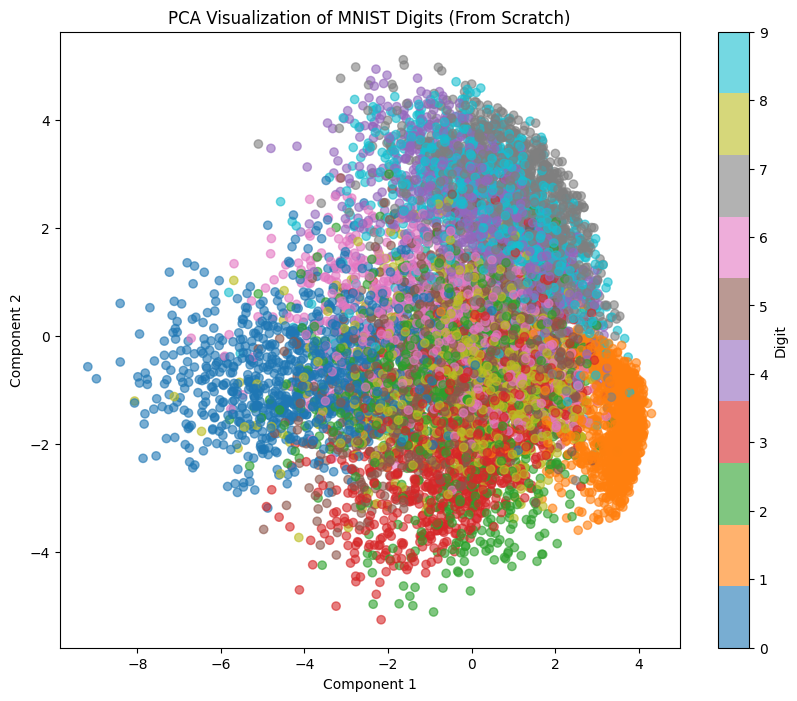

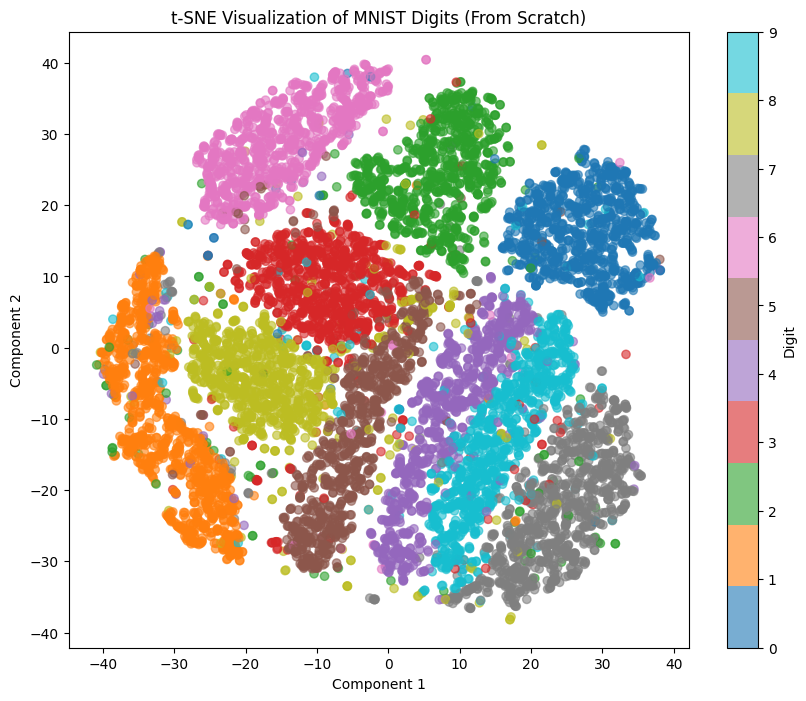

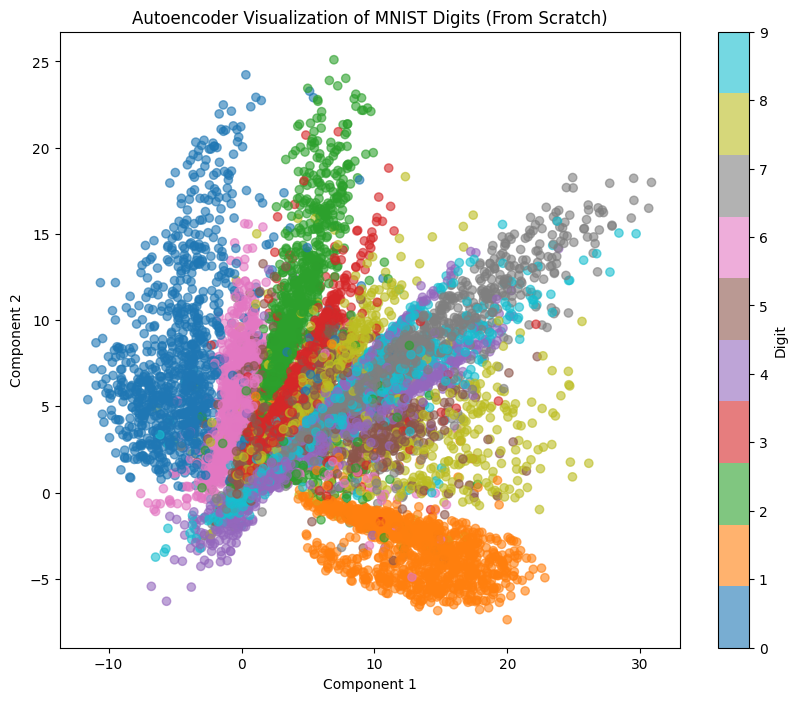

In [18]:
# Generate 2D scatter plots for each technique, coloring the points based on their digit labels (0-9).
def plot_embeddings(X_emb, y, title, filename=None):
    """Plot 2D embeddings with digit labels"""
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    if filename:
        plt.savefig(f"./visualizations/{filename}")
    plt.show()

# Plot results
plot_embeddings(X_pca, y_sample, "PCA Visualization of MNIST Digits (From Scratch)", "pca_class.png")
plot_embeddings(X_tsne, y_sample, "t-SNE Visualization of MNIST Digits (From Scratch)", "tsne_class.png")
plot_embeddings(X_ae, y_sample, "Autoencoder Visualization of MNIST Digits (From Scratch)", "ae_class.png")

# Analysis Report

### Determine which digits are better represented by each technique.

When examining 2D visualizations, both PCA and the Autoencoder performed well at separating digits '0' and '1', with the Autoencoder offering slightly better visual clarity for '0'. These digits consistently formed the most distinct and well-separated clusters across all methods. Overall, t-SNE outperformed both PCA and the Autoencoder in separating all digit classes, providing the clearest visual distinction between clusters.

### Analyze the clustering and separation of different digit classes.

The Autoencoder and PCA showed similar clustering patterns, particularly overlapping digits with visual similarity, such as '4', '7', and '9', as well as '3' and '8'. However, the Autoencoder provided slightly better separation for '3' and '8'. In contrast, PCA struggled significantly with digit '6', which appeared to blend into multiple other clusters. This is expected, given the loss of information during linear dimensionality reduction.

t-SNE also showed some adjacency among these similar digits, but instead of one large mixed cluster, it placed them near each other with minimal overlap. This reflects t-SNE’s strength in preserving local structure, even in challenging cases.

### Each dimensionality reduction technique brings distinct advantages and disadvantages when applied to a dataset like MNIST:

PCA (Principal Component Analysis):
- Strengths: Fast and computationally efficient, PCA provides a clear measure of explained variance. It performs well on digits like '0' and '1' that lie on relatively linear manifolds.
- Weaknesses: As a linear technique, PCA cannot model the non-linear structures common in image data. It tends to preserve global distances but not local patterns, leading to poor separability for complex digits like '3' and '8'.

Autoencoders:
- Strengths: With non-linear activation functions, Autoencoders can capture complex, non-linear relationships. They often outperform PCA in separating visually similar digits.
- Weaknesses: If not carefully designed, for example, with a narrow bottleneck or regularization, Autoencoders may simply learn to reproduce the input without meaningful dimension reduction.

t-SNE (t-Distributed Stochastic Neighbor Embedding):
- Strengths: t-SNE excels at creating clear, visually distinct clusters by preserving local relationships. It’s ideal for visualization and can uncover latent patterns in complex data.
- Weaknesses: It’s computationally expensive and not scalable to very high-dimensional outputs. Results can vary depending on initialization and parameter choices, and it doesn’t preserve global structure well. It’s also not ideal for dimensions higher than 3 or can be used as input for algorithms.

## Discuss computational efficiency and scalability.
Due to the size of the dataset being 70,000, a random subset of datapoints had to be used for computational feasibility. Due to the space-time complexiy of $O(n^2)$ for very large datasets, t-SNE can be computationally intensive compared to linear methods like PCA. Similarly for deep autoencoders that look at non-linear relationships. Due to this, I adjusted the sample size to a random 10,000 instances, as recommended by the t-SNE seminal paper.

## Provide insights into why certain digits are better or worse represented by specific techniques based on their underlying mechanisms.
PCA (Linear):
- Good For: '0' and '1'. Their simpler, more linear shapes are easily captured by PCA's linear projections, preserving distinctness.
- Bad For: '3', '8', '4', '7', '9'. PCA struggles with their complex curves and visual ambiguities because it cannot model non-linear relationships. This leads to significant overlap especially when looking at the slight curvilinear differences between numbers lik 3 and 8.

Autoencoder
- Presents crowding problem where data points are localized around the center of the map in the 2D space

t-SNE (Non-linear, Local Focus):
- Best Overall: Excels at all digits, especially complex ones like '3', '8', '4', '7', '9'. Its focus on preserving local neighborhood structures allows it to effectively separate visually similar digits by emphasizing subtle, non-linear distinctions.